# HW 10 CLUSTERING BUSINESS

# cluster time trends in NYC businesses: 
# DATA
# Census Business data:
## download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##  you can  download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [3]:
import os 

In [384]:
import pandas as pd
import zipfile #i am not giving it a name cause i intend to use it only once
import glob
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
import seaborn
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline
path = os.getenv("PUIDATA")

In [100]:
os.chdir(path)
allfname = glob.glob("*.zip")

# NYC zip codes shape file is here
## http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981

This website id currently down. I uploaded the geojson file in the github repo as well

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

The map of the clusters may look something like this

In [125]:
zipcode = gp.GeoDataFrame.from_file('nyc-zip-code-tabulation-areas-polygons.geojson')

In [126]:
zipcode.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [141]:
def func_(f):
    tmp = pd.read_csv(zipfile.ZipFile(f).open(f.replace('.zip','.txt')))
    tmp["Year"] = f[3:5]
    return tmp
df = pd.concat(func_(f) for f in allfname)

In [142]:
df.head()

,AP,EMP,EMPFLAG,EST,NAME,QP1,Year,ZIP,ap,ap_nf,...,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,zip
0,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,155158.0,NaN,...,NaN,6198.0,NaN,NaN,439.0,"Agawam, MA",33601.0,NaN,NaN,1001.0
1,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,127367.0,NaN,...,NaN,6073.0,NaN,NaN,450.0,"Amherst, MA",28924.0,NaN,NaN,1002.0
2,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,1604.0,NaN,...,NaN,68.0,NaN,NaN,10.0,"Amherst, MA",367.0,NaN,NaN,1003.0
3,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,4302.0,NaN,...,NaN,210.0,NaN,NaN,47.0,"Amherst, MA",844.0,NaN,NaN,1004.0
4,NaN,NaN,NaN,NaN,NaN,NaN,94,NaN,13521.0,NaN,...,NaN,678.0,NaN,NaN,92.0,"Barre, MA",3010.0,NaN,NaN,1005.0


In [195]:
df = df[df["ZIP"].isin(zipcode["postalCode"].astype(float)) | df["zip"].isin(zipcode["postalCode"].astype(float))]

In [210]:
df.head()

,AP,EMP,EMPFLAG,EST,NAME,QP1,Year,ZIP,ap,ap_nf,...,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,zip
0,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,3375875.0,NaN,...,NaN,106160.0,NaN,NaN,6999.0,"New York, NY",781628.0,NaN,NaN,10001.0
1,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,258318.0,NaN,...,NaN,13500.0,NaN,NaN,1784.0,"New York, NY",60207.0,NaN,NaN,10002.0
2,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,2194890.0,NaN,...,NaN,59001.0,NaN,NaN,3256.0,"New York, NY",497286.0,NaN,NaN,10003.0
3,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,2615639.0,NaN,...,NaN,39428.0,NaN,NaN,1115.0,"New York, NY",685819.0,NaN,NaN,10004.0
4,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,2937365.0,NaN,...,NaN,43540.0,NaN,NaN,1076.0,"New York, NY",807612.0,NaN,NaN,10005.0


In [206]:
df.Year = pd.to_datetime(df.Year, format="%y").dt.year

In [208]:
df.reset_index(drop=True, inplace=1)

In [209]:
df.head()

,AP,EMP,EMPFLAG,EST,NAME,QP1,Year,ZIP,ap,ap_nf,...,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,zip
0,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,3375875.0,NaN,...,NaN,106160.0,NaN,NaN,6999.0,"New York, NY",781628.0,NaN,NaN,10001.0
1,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,258318.0,NaN,...,NaN,13500.0,NaN,NaN,1784.0,"New York, NY",60207.0,NaN,NaN,10002.0
2,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,2194890.0,NaN,...,NaN,59001.0,NaN,NaN,3256.0,"New York, NY",497286.0,NaN,NaN,10003.0
3,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,2615639.0,NaN,...,NaN,39428.0,NaN,NaN,1115.0,"New York, NY",685819.0,NaN,NaN,10004.0
4,NaN,NaN,NaN,NaN,NaN,NaN,1994,NaN,2937365.0,NaN,...,NaN,43540.0,NaN,NaN,1076.0,"New York, NY",807612.0,NaN,NaN,10005.0


In [225]:
df_merge = pd.concat([df[["EST", "ZIP", "Year"]].dropna().rename(columns={"EST":"est", "ZIP":"zip"}), 
                      df[["est", "zip", "Year"]].dropna()])

In [227]:
df_merge.reset_index(drop=True, inplace=True)

In [239]:
df_merge.head()

,est,zip,Year
0,7254.0,10001.0,1998
1,2003.0,10002.0,1998
2,3649.0,10003.0,1998
3,1176.0,10004.0,1998
4,1270.0,10005.0,1998


In [238]:
df_merge.shape

(5014, 3)

In [244]:
mydata = df_merge.pivot(index="zip", columns="Year", values="est")

In [266]:
mydatastd = mydata.apply(lambda x: (x - x.mean())/x.std(), axis=1)

In [271]:
mydatastd.fillna(0, inplace=1)

In [290]:
mydatastd.shape

(244, 21)

In [482]:
Kcluster = KMeans(n_clusters=5).fit(mydatastd)

In [483]:
Kcluster.labels_.shape

(244,)

(1994, 2014)

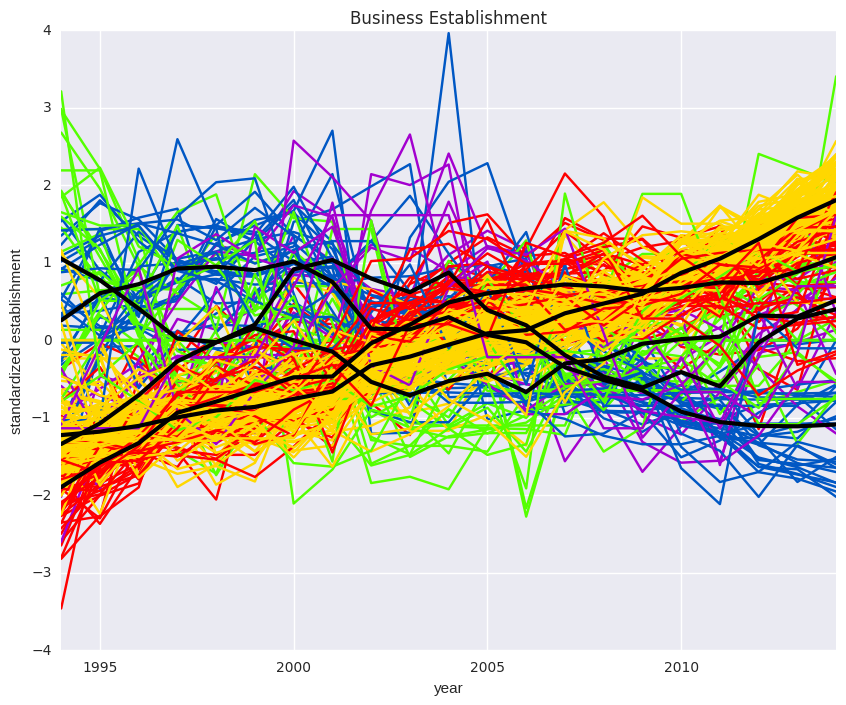

In [388]:
cmap = plt.cm.prism(np.linspace(0,1,5))
plt.figure(figsize=(10,8))
for i in range(len(mydatastd)):
    c = Kcluster.labels_[i]
    plt.plot(range(1994,2015), mydatastd.iloc[i,:21], color=cmap[c][:3])
for i in range(len(Kcluster.cluster_centers_)):
    plt.plot(range(1994,2015), Kcluster.cluster_centers_[i], color="black", linewidth=3)
plt.title("Business Establishment")
plt.ylabel("standardized establishment")
plt.xlabel("year")
plt.xlim(1994,2014)

In [374]:
Z = linkage(mydatastd.iloc[:,:21].values, 'ward')

In [355]:
from scipy.cluster.hierarchy import set_link_color_palette
set_link_color_palette(['black'])

In [382]:
plt.figure(figsize=(20, 500))
plt.title('Hierarchical Clustering Dendrogram', fontsize=50)
dendrogram(
    Z,
    color_threshold=np.inf,
    orientation="left",
    labels = mydatastd.iloc[:,:21].index.values,
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

In [484]:
AC = AgglomerativeClustering(n_clusters=5, linkage="ward").fit(mydatastd.iloc[:,:21])

In [485]:
KMdf = pd.DataFrame({"zip":mydatastd.index.values, "label":Kcluster.labels_})
ACdf = pd.DataFrame({"zip":mydatastd.index.values, "label":AC.labels_})

In [486]:
zipcode.rename(columns={"postalCode":"zip"}, inplace=1)

In [487]:
zipcode["zip"] = pd.to_numeric(zipcode["zip"])

In [488]:
zipdf = zipcode.merge(KMdf, on="zip").merge(ACdf, on="zip")

In [489]:
zipdf.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,zip,label_x,label_y
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,0,3
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,0,3
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,0,3
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,4,2
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,0,3


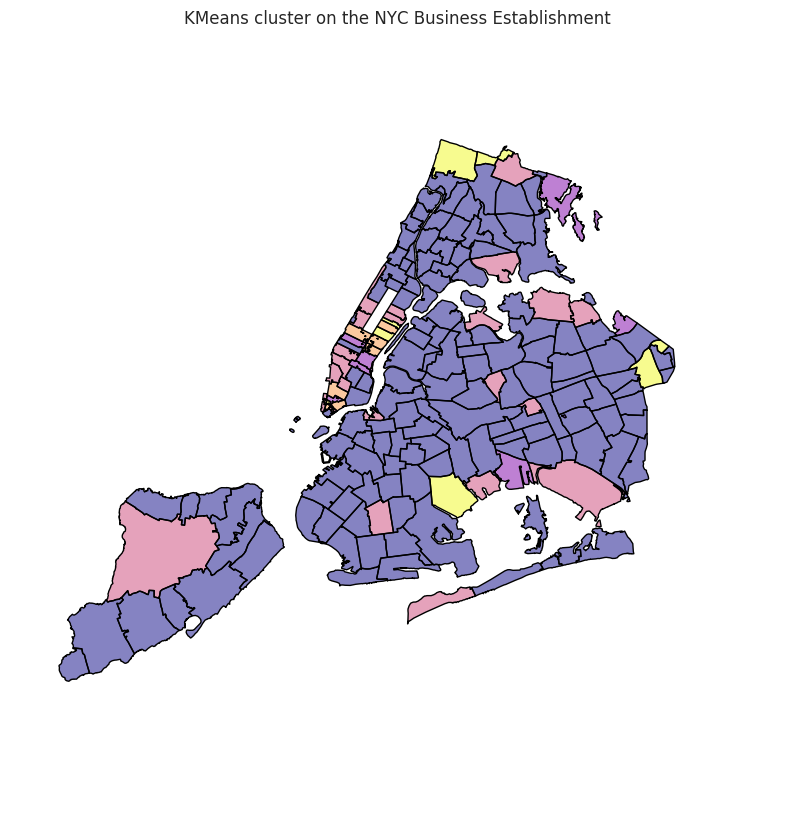

In [490]:
f, ax = plt.subplots(figsize=(10,10))
zipdf.plot(column="label_x", cmap="plasma", figsize=(15,10), ax=ax)
ax.set_title("KMeans cluster on the NYC Business Establishment")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_axis_bgcolor('white') 

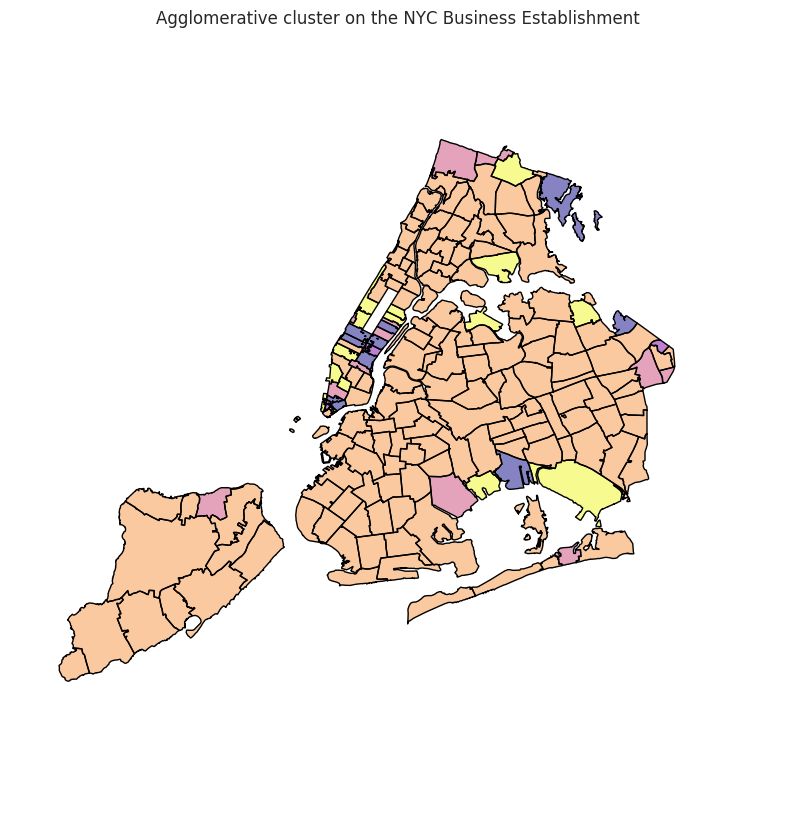

In [491]:
f, ax = plt.subplots(figsize=(10,10))
zipdf.plot(column="label_y", cmap="plasma", figsize=(15,10), ax=ax)
ax.set_title("Agglomerative cluster on the NYC Business Establishment")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_axis_bgcolor('white') 

### From both plots, we can see the cluster results are similar, and both seem reasonable. However, there are some difference, which may arised from the randomness of the two algorithmns. 

### As is shown in the plots here, most of the regions follow the same temporal pattern, yet a small part of the zipcodes have different patterns, given more data we can further investigate why this happens, why these palces are special.